# Notebook to check the EC on Dust Torus by Julian

In [1]:
import sys
sys.path.append("../../")
import numpy as np
import astropy.units as u
from astropy.constants import m_e, c, M_sun, sigma_T
from astropy.coordinates import Distance
from agnpy.emission_regions import Blob
from agnpy.targets import RingDustTorus
from agnpy.absorption import Absorption
from agnpy.tests.utils import make_comparison_plot
from agnpy.utils.conversion import mec2
import matplotlib.pyplot as plt

In [2]:
# load Finke's points
sample_table = np.loadtxt(f"../../data/sampled_taus/tau_dt_figure_14_finke_2016.txt", delimiter=",", comments="#")
E_ref = sample_table[:, 0] * u.Unit("GeV")
tau_ref = sample_table[:, 1]
nu_ref = E_ref.to("Hz", equivalencies=u.spectral())

In [3]:
# test blob
spectrum_norm_test = 1e48 * u.Unit("erg")
p_test = 2.8
gamma_min_test = 1e2
gamma_max_test = 1e5
pwl_dict_test = {
    "type": "PowerLaw",
    "parameters": {
        "p": p_test,
        "gamma_min": gamma_min_test,
        "gamma_max": gamma_max_test,
    },
}
# blob parameters
pwl_blob_test = Blob(1e16 * u.cm, 0, 10, 10, 1 * u.G, spectrum_norm_test, pwl_dict_test)


# parameters and agnpy calculation
L_disk = 2e46 * u.Unit("erg s-1")
T_dt = 1e3 * u.K
csi_dt = 0.1
dt = RingDustTorus(L_disk, csi_dt, T_dt)
R_dt = dt.R_dt
print("R_dt=",R_dt)
r = 1.1e16 * u.cm
# recompute the tau, use the full energy range of figure 14
ec_dt = Absorption(pwl_blob_test, dt, r)
tau_agnpy = ec_dt.tau(nu_ref)

R_dt= 1.565247584249853e+19 cm


/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


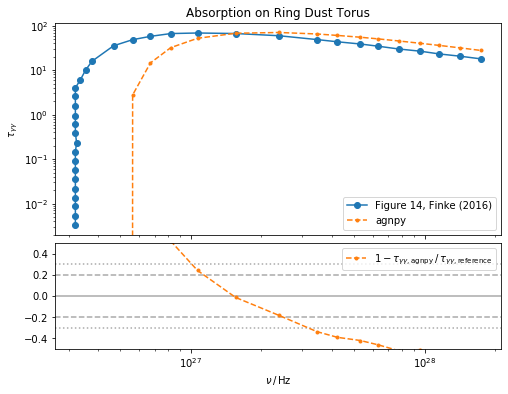

In [4]:
# the reference curve is multiplied by a factor 2 because this is missing in the emissivity definition of Finke
make_comparison_plot(
            nu_ref,
            2 * tau_ref,
            tau_agnpy,
            "Figure 14, Finke (2016)",
            "agnpy",
            "Absorption on Ring Dust Torus",
            "./test_dt.png",
            "tau",
        )

In [16]:
# back of envelope calculations, threshold
eps=dt.epsilon_dt * mec2 # energy of DT photons
#print(eps.to("eV"))
r0=np.sqrt(R_dt**2 + r**2)
mu=r/r0
e_thr=(2*mec2**2)/(eps*(1-mu))
nu_thr = e_thr.to("Hz", equivalencies=u.spectral())
print("Energy threshold, Finke=",e_thr.to("TeV"))
print("Nu threshold, back of the envelope=",nu_thr)
print("Nu threshold, Finke=", nu_ref[0])
print("Nu threshold, agnpy=", nu_ref[tau_agnpy>0][0])

Energy threshold, Finke= 2.2461495676633727 TeV
Nu threshold, back of the envelope= 5.4311654907237244e+26 Hz
Nu threshold, Finke= 3.209327985112649e+26 Hz
Nu threshold, agnpy= 5.639562857194919e+26 Hz


the threshold value obtained from simple calculations is very similar to the one obtained in agnpy, but twice larger then  from Finke's paper. Assuming that the points really correspond to this temperature of the disk and that the geometry is not drastically different the most probable cause would be that the energy of DT photons is treated differently. Is Finke using monoenergetic approximation also for absorption? The absorption at the threshold is very sensitive to this energy spectrum of the soft photons. 

In [6]:
def sigma_pp(b):
    return sigma_T * 3./16. * (1-b**2)*(2*b*(b**2 - 2 )+(3-b**4)*np.log((1+b)/(1-b))) 

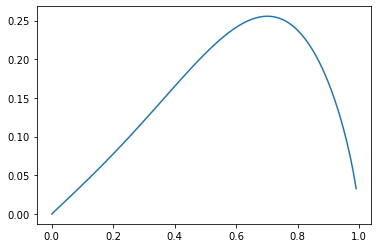

In [7]:
betas=np.arange(0,1, 0.01)
sigmas=sigma_pp(betas)/(sigma_T )
plt.plot(betas, sigmas)

In [8]:
# now compute the actual tau at 2 TeV
# first range of distances up to 10* R_s where to compute absorption
distmax=10*R_dt
nbins = int(np.log(distmax/r)/np.log(1.03)) # each bin is a 3% raise in distance
rs=np.logspace(np.log10(r/u.cm).value, np.log10(distmax/u.cm).value, nbins)*u.cm
drs=rs[1:]-rs[:-1]
rs=rs[:-1]

r0s=np.sqrt(rs**2+R_dt**2)
mus=rs/r0s

# density of radiation field
n_ph = (L_disk*csi_dt/ eps / (4*np.pi * r0s**2 *c)).to("cm-3")

E=(2.e27* u.Hz).to("eV", equivalencies=u.spectral())
beta2=1-2*mec2**2/(E*eps*(1-mus))
above_thr=beta2>0
sigmas=sigma_pp(np.sqrt(beta2[above_thr])).to("cm2")

taus = (n_ph[above_thr]*(1-mus[above_thr])*sigmas*drs[above_thr]).to("")
tau = taus.sum()
print(tau)
# the value is consistent with both curves

70.11805807186008


70.11805807186008


/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


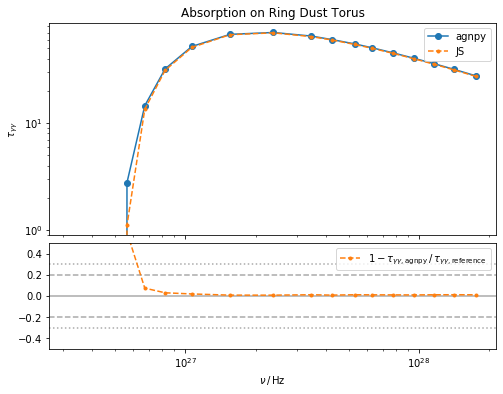

In [9]:
# geometrical part
distmax=10*R_dt
nbins_r = int(np.log(distmax/r)/np.log(1.03)) # each bin is a 3% raise in distance
rs=np.logspace(np.log10(r/u.cm).value, np.log10(distmax/u.cm).value, nbins_r+1)*u.cm
drs=rs[1:]-rs[:-1]
rs=rs[:-1]

r0s=np.sqrt(rs**2+R_dt**2)
mus=rs/r0s

# density of radiation field
n_ph = (L_disk*csi_dt/ eps / (4*np.pi * r0s**2 *c)).to("cm-3")

#0th axis- distance, 1st axis - energy
Es=(nu_ref).to("eV", equivalencies=u.spectral())
nbins_e = Es.shape[0]
Es=np.tile(Es, (nbins_r, 1))

mus=np.tile(mus, (nbins_e,1)).transpose()
n_ph=np.tile(n_ph, (nbins_e,1)).transpose()
drs=np.tile(drs, (nbins_e,1)).transpose()

beta2=1-2*mec2**2/(Es*eps*(1-mus))
beta2[beta2<0]=0  # set to 0 values below the threshold

sigmas=sigma_pp(np.sqrt(beta2)).to("cm2")
#print(sigmas)

taus = (n_ph*(1-mus)*sigmas*drs).to("")
tau_js = taus.sum(axis=0)
print(tau)

make_comparison_plot(
            nu_ref,
            tau_agnpy,
            tau_js,
            "agnpy",
            "JS",
            "Absorption on Ring Dust Torus",
            "./test_dt_js.png",
            "tau",
        )

In [10]:
(1.2* u.Unit("TeV")).to("Hz", equivalencies=u.spectral())

<Quantity 2.90158709e+26 Hz>

/home/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


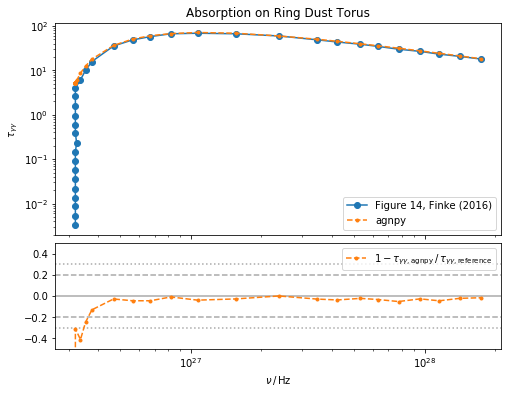

In [11]:
# now check if the problem is not simply redshift of the sourse
z=0.85
nu_src=(1+z)*nu_ref
tau_z = ec_dt.tau(nu_src)
make_comparison_plot(
            nu_ref,
            2 * tau_ref,
            tau_z,
            "Figure 14, Finke (2016)",
            "agnpy",
            "Absorption on Ring Dust Torus",
            "./test_dt_z.png",
            "tau",
        )